In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
from scipy.signal import butter, filtfilt

## Original EEG data (raw data) and its figure

Extracting EDF parameters from /Users/kris/Desktop/COGS189/COGS189_FinalProject/files/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


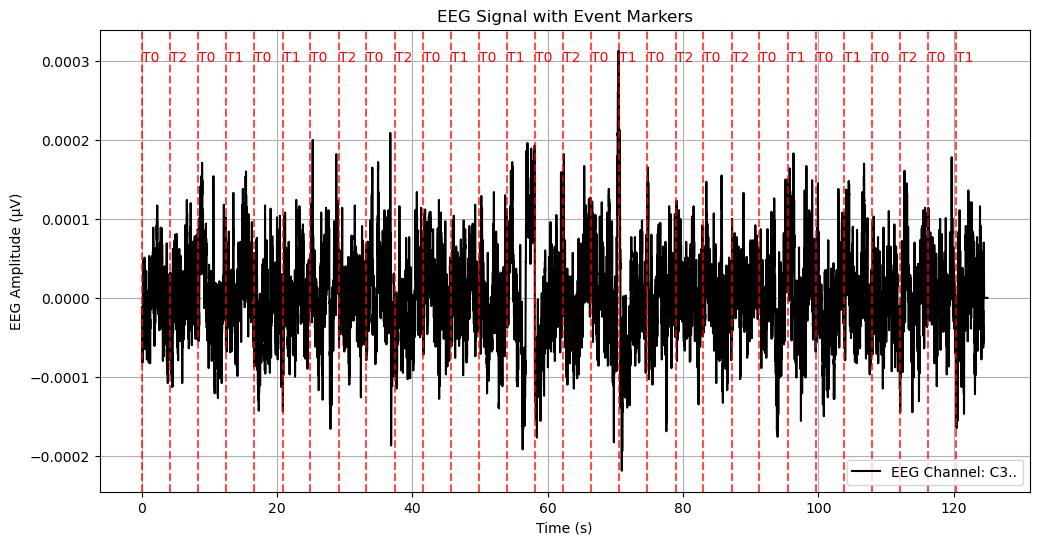

Not setting metadata
30 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)


/var/folders/g7/2jrpz1td1gvfhtddsqp_957c0000gn/T/ipykernel_79584/2136492491.py:48: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)
/opt/anaconda3/lib/python3.12/site-packages/mne/viz/utils.py:137: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


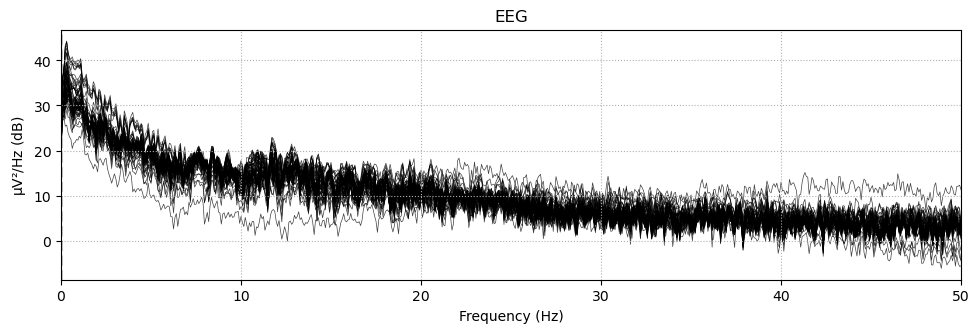

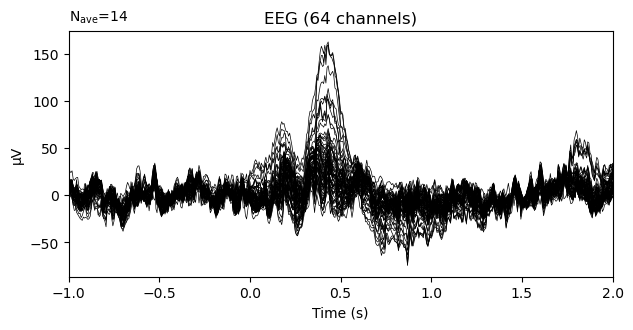

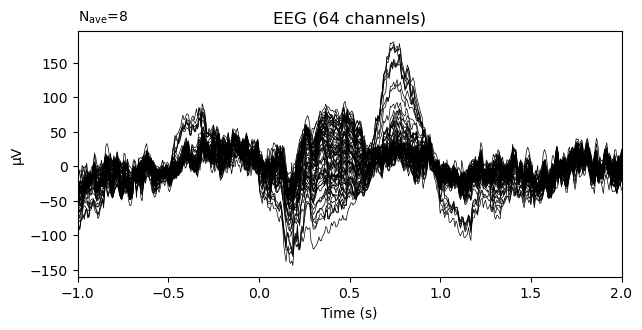

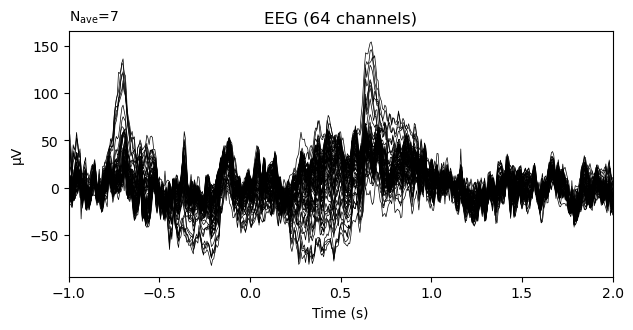

In [6]:
edf_file_path = "./files/S001/S001R03.edf"
event_file_path = "./files/S001/S001R03.edf.event"
raw = mne.io.read_raw_edf(edf_file_path, preload=True)

# Read EEG data
eeg_data, times = raw[:,:]

# Read event markers
event_times = raw.annotations.onset  # event times
event_labels = raw.annotations.description  # event labels

# Read event data
with open(event_file_path, "rb") as f:
    event_data = f.read()

# Decode event data
decoded_text = event_data.decode("utf-8", errors="ignore")
event_pattern = re.findall(r'(T[012]) duration: (\d+\.\d+)', decoded_text)
parsed_events = [{"Event": match[0], "Duration (s)": float(match[1])} for match in event_pattern]
df_events = pd.DataFrame(parsed_events)

# Select EEG channel
channel_idx = raw.ch_names.index("C3..") # most important channel for motor movement
eeg_signal = eeg_data[channel_idx]

# 1. Plot EEG signal with event markers
plt.figure(figsize=(12, 6))
plt.plot(times, eeg_signal, label=f"EEG Channel: {raw.ch_names[channel_idx]}", color="black")

for etime, elabel in zip(event_times, event_labels):
    plt.axvline(x=etime, color="red", linestyle="--", alpha=0.7)
    plt.text(etime, np.max(eeg_signal), elabel, color="red", fontsize=10, verticalalignment='top')

plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Signal with Event Markers")
plt.legend()
plt.grid()
plt.show()

# 2. (T0, T1, T2) event markers
event_id = {"T0": 1, "T1": 2, "T2": 3}
events = np.array([[int(t * raw.info["sfreq"]), 0, event_id[l]] for t, l in zip(event_times, event_labels)])

epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-1.0, tmax=2.0, baseline=(None, 0), detrend=1)

# 3. Plot Power Spectral Density (PSD)
raw.plot_psd(fmax=50)

# 4. Plot Event-Related Potential (ERP)
evoked_T0 = epochs['T0'].average()
evoked_T1 = epochs['T1'].average()
evoked_T2 = epochs['T2'].average()

fig = evoked_T0.plot()
fig = evoked_T1.plot() # ERP for T1 (Left/Both Fist Movement)
fig = evoked_T2.plot() # "ERP for T2 (Right Fist/Both Feet Movement)


## Task 1

In [3]:
def butter_lowpass_filter(data, cutoff=30, fs=160, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

Extracting EDF parameters from /Users/kris/Desktop/COGS189/COGS189_FinalProject/files/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 529 samples (3.306 sec)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) met

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


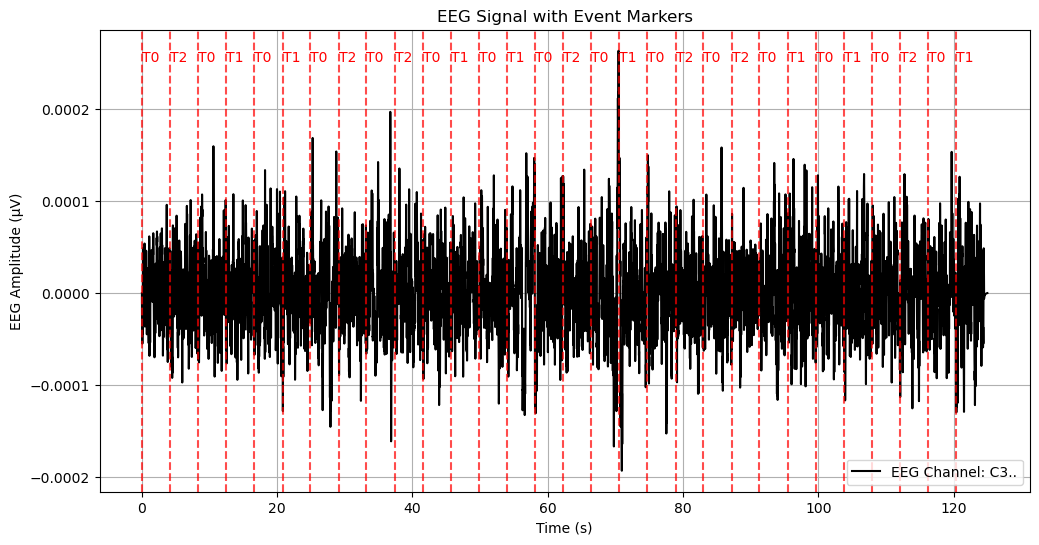

Not setting metadata
30 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)


/var/folders/g7/2jrpz1td1gvfhtddsqp_957c0000gn/T/ipykernel_73152/651297638.py:65: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)
/opt/anaconda3/lib/python3.12/site-packages/mne/viz/utils.py:137: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


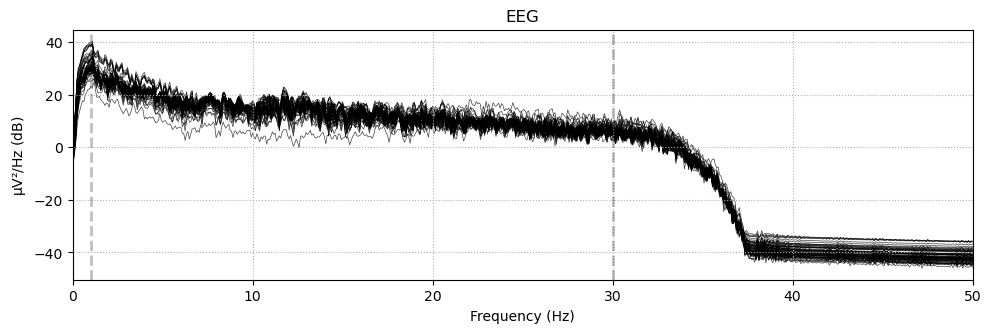

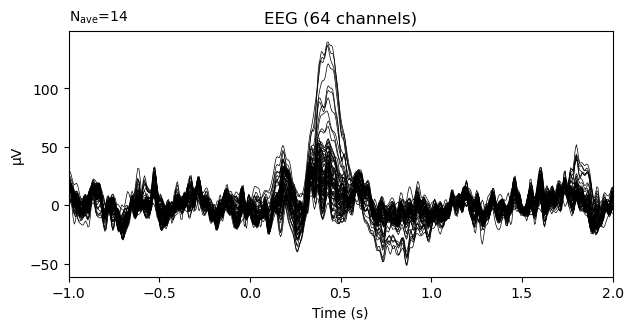

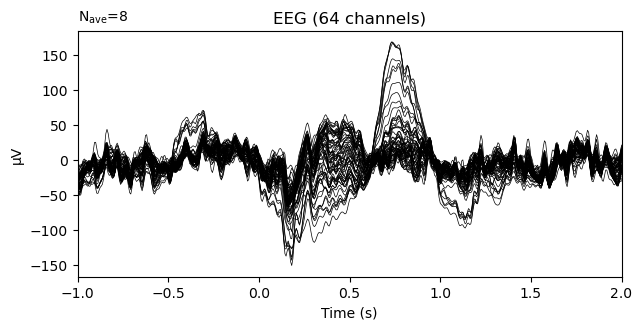

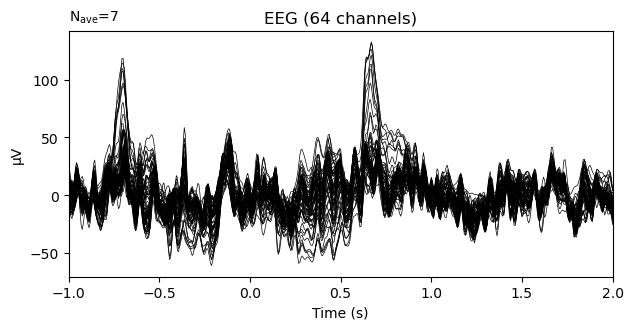

In [4]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
from scipy.signal import butter, filtfilt


edf_file_path = "./files/S001/S001R03.edf"
event_file_path = "./files/S001/S001R03.edf.event"
raw = mne.io.read_raw_edf(edf_file_path, preload=True)

# apply band-pass filter
raw.filter(1, 30, fir_design='firwin')
raw.notch_filter(60, fir_design='firwin')


# Read EEG data
eeg_data, times = raw[:,:]

# Read event markers
event_times = raw.annotations.onset  # event times
event_labels = raw.annotations.description  # event labels

# Read event data
with open(event_file_path, "rb") as f:
    event_data = f.read()

# Decode event data
decoded_text = event_data.decode("utf-8", errors="ignore")
event_pattern = re.findall(r'(T[012]) duration: (\d+\.\d+)', decoded_text)
parsed_events = [{"Event": match[0], "Duration (s)": float(match[1])} for match in event_pattern]
df_events = pd.DataFrame(parsed_events)

# Select EEG channel
channel_idx = raw.ch_names.index("C3..") # most important channel for motor movement
eeg_signal = eeg_data[channel_idx]

# apply low-pass filter
eeg_signal = butter_lowpass_filter(eeg_signal, cutoff=30, fs=160, order=4)


# 1. Plot EEG signal with event markers
plt.figure(figsize=(12, 6))
plt.plot(times, eeg_signal, label=f"EEG Channel: {raw.ch_names[channel_idx]}", color="black")

for etime, elabel in zip(event_times, event_labels):
    plt.axvline(x=etime, color="red", linestyle="--", alpha=0.7)
    plt.text(etime, np.max(eeg_signal), elabel, color="red", fontsize=10, verticalalignment='top')

plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Signal with Event Markers")
plt.legend()
plt.grid()
plt.show()

# 2. (T0, T1, T2) event markers
event_id = {"T0": 1, "T1": 2, "T2": 3}
events = np.array([[int(t * raw.info["sfreq"]), 0, event_id[l]] for t, l in zip(event_times, event_labels)])

epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-1.0, tmax=2.0, baseline=(None, 0), detrend=1)

# 3. Plot Power Spectral Density (PSD)
raw.plot_psd(fmax=50)

# 4. Plot Event-Related Potential (ERP)
evoked_T0 = epochs['T0'].average()
evoked_T1 = epochs['T1'].average()
evoked_T2 = epochs['T2'].average()

fig = evoked_T0.plot()
fig = evoked_T1.plot() # ERP for T1 (Left/Both Fist Movement)
fig = evoked_T2.plot() # "ERP for T2 (Right Fist/Both Feet Movement)


## Task 2

Extracting EDF parameters from /Users/kris/Desktop/COGS189/COGS189_FinalProject/files/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 529 samples (3.306 sec)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) met

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


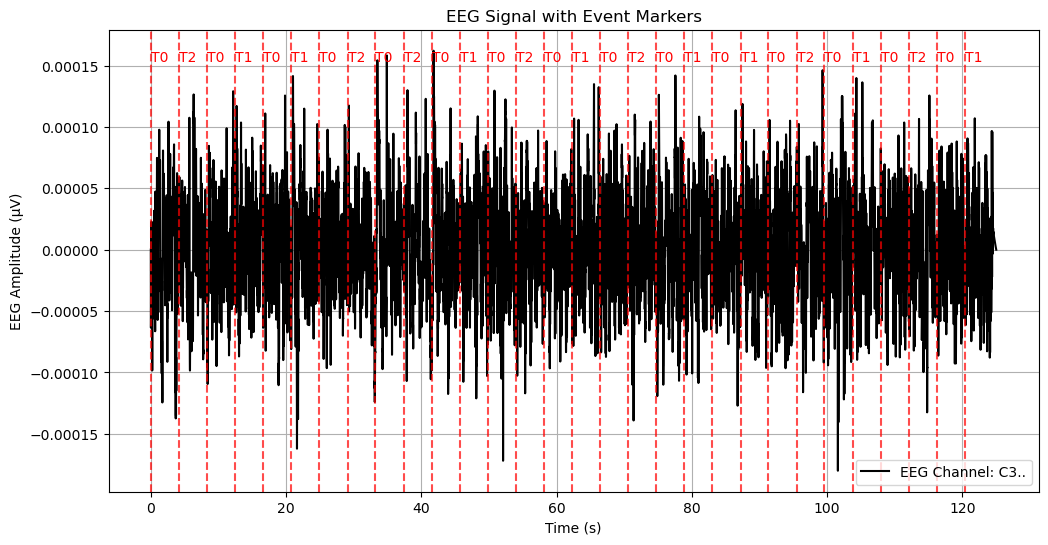

Not setting metadata
30 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)


/var/folders/g7/2jrpz1td1gvfhtddsqp_957c0000gn/T/ipykernel_73152/500243989.py:57: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)
/opt/anaconda3/lib/python3.12/site-packages/mne/viz/utils.py:137: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


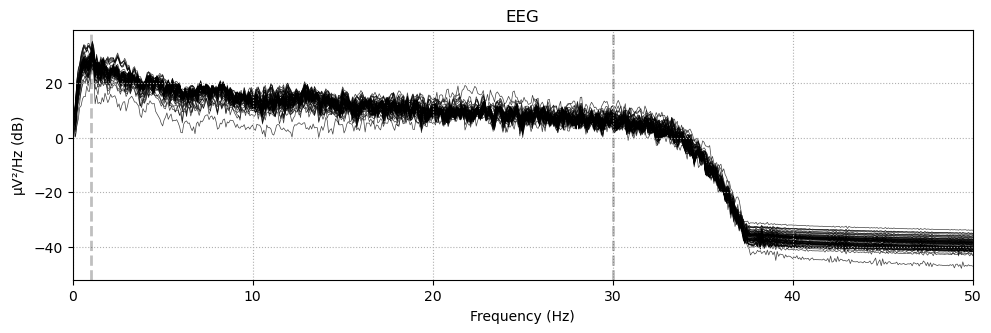

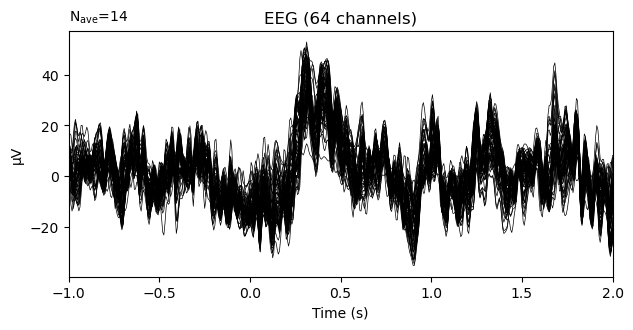

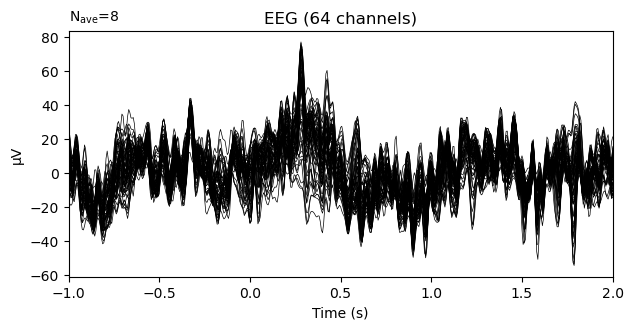

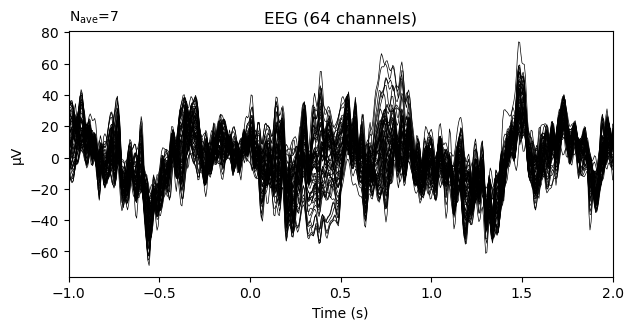

In [5]:
edf_file_path = "./files/S001/S001R04.edf"
event_file_path = "./files/S001/S001R04.edf.event"
raw = mne.io.read_raw_edf(edf_file_path, preload=True)

# apply band-pass filter
raw.filter(1, 30, fir_design='firwin')
raw.notch_filter(60, fir_design='firwin')


# Read EEG data
eeg_data, times = raw[:,:]

# Read event markers
event_times = raw.annotations.onset  # event times
event_labels = raw.annotations.description  # event labels

# Read event data
with open(event_file_path, "rb") as f:
    event_data = f.read()

# Decode event data
decoded_text = event_data.decode("utf-8", errors="ignore")
event_pattern = re.findall(r'(T[012]) duration: (\d+\.\d+)', decoded_text)
parsed_events = [{"Event": match[0], "Duration (s)": float(match[1])} for match in event_pattern]
df_events = pd.DataFrame(parsed_events)

# Select EEG channel
channel_idx = raw.ch_names.index("C3..") # most important channel for motor movement
eeg_signal = eeg_data[channel_idx]

# apply low-pass filter
eeg_signal = butter_lowpass_filter(eeg_signal, cutoff=30, fs=160, order=4)


# 1. Plot EEG signal with event markers
plt.figure(figsize=(12, 6))
plt.plot(times, eeg_signal, label=f"EEG Channel: {raw.ch_names[channel_idx]}", color="black")

for etime, elabel in zip(event_times, event_labels):
    plt.axvline(x=etime, color="red", linestyle="--", alpha=0.7)
    plt.text(etime, np.max(eeg_signal), elabel, color="red", fontsize=10, verticalalignment='top')

plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Signal with Event Markers")
plt.legend()
plt.grid()
plt.show()

# 2. (T0, T1, T2) event markers
event_id = {"T0": 1, "T1": 2, "T2": 3}
events = np.array([[int(t * raw.info["sfreq"]), 0, event_id[l]] for t, l in zip(event_times, event_labels)])

epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-1.0, tmax=2.0, baseline=(None, 0), detrend=1)

# 3. Plot Power Spectral Density (PSD)
raw.plot_psd(fmax=50)

# 4. Plot Event-Related Potential (ERP)
evoked_T0 = epochs['T0'].average()
evoked_T1 = epochs['T1'].average()
evoked_T2 = epochs['T2'].average()

fig = evoked_T0.plot()
fig = evoked_T1.plot() # ERP for T1 (Left/Both Fist Movement)
fig = evoked_T2.plot() # "ERP for T2 (Right Fist/Both Feet Movement)


## Task 3

Extracting EDF parameters from /Users/kris/Desktop/COGS189/COGS189_FinalProject/files/S001/S001R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 529 samples (3.306 sec)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) met

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


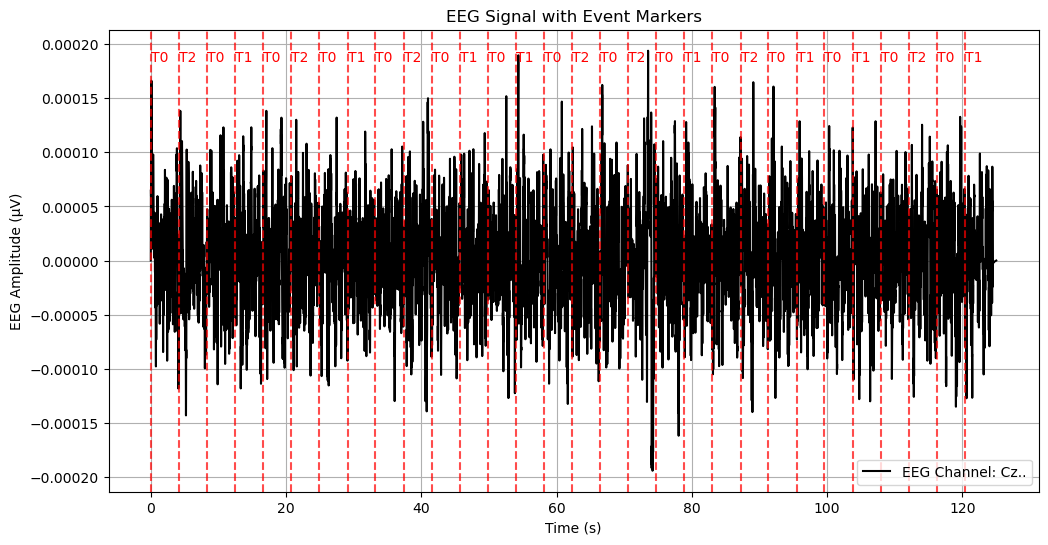

Not setting metadata
30 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)


/var/folders/g7/2jrpz1td1gvfhtddsqp_957c0000gn/T/ipykernel_73152/3016030438.py:57: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)
/opt/anaconda3/lib/python3.12/site-packages/mne/viz/utils.py:137: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


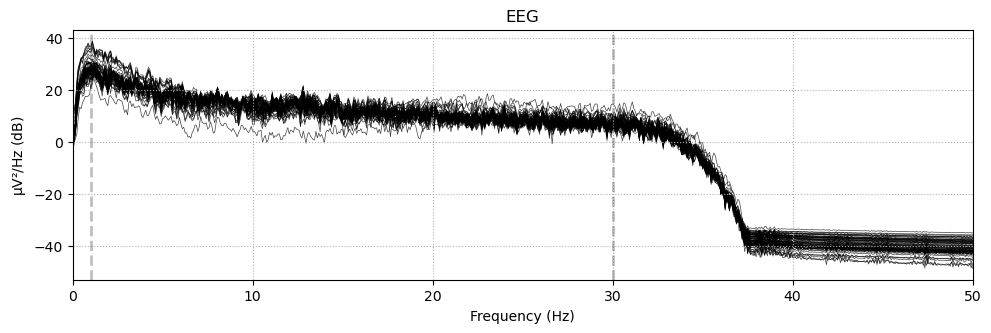

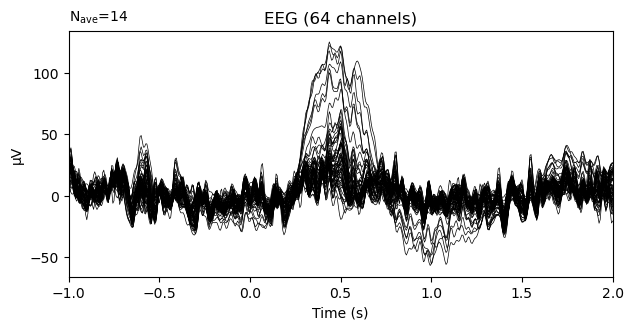

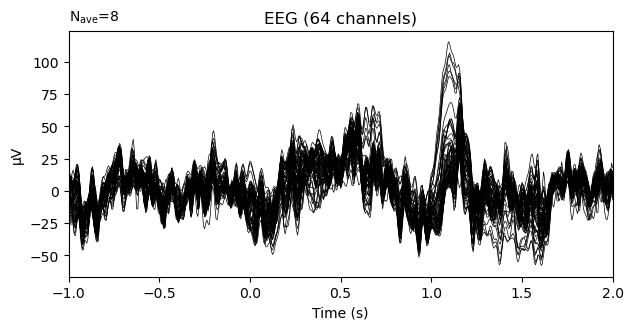

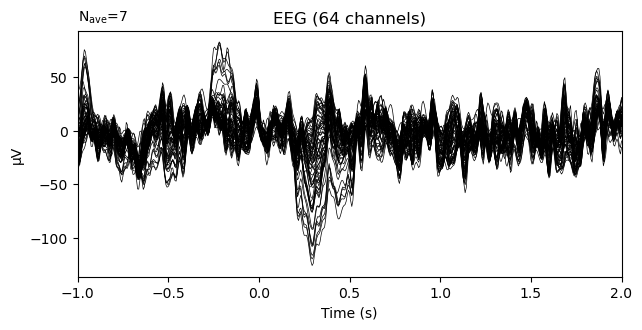

In [6]:
edf_file_path = "./files/S001/S001R05.edf"
event_file_path = "./files/S001/S001R05.edf.event"
raw = mne.io.read_raw_edf(edf_file_path, preload=True)

# apply band-pass filter
raw.filter(1, 30, fir_design='firwin')
raw.notch_filter(60, fir_design='firwin')


# Read EEG data
eeg_data, times = raw[:,:]

# Read event markers
event_times = raw.annotations.onset  # event times
event_labels = raw.annotations.description  # event labels

# Read event data
with open(event_file_path, "rb") as f:
    event_data = f.read()

# Decode event data
decoded_text = event_data.decode("utf-8", errors="ignore")
event_pattern = re.findall(r'(T[012]) duration: (\d+\.\d+)', decoded_text)
parsed_events = [{"Event": match[0], "Duration (s)": float(match[1])} for match in event_pattern]
df_events = pd.DataFrame(parsed_events)

# Select EEG channel
channel_idx = raw.ch_names.index("Cz..") # most important channel for motor movement
eeg_signal = eeg_data[channel_idx]

# apply low-pass filter
eeg_signal = butter_lowpass_filter(eeg_signal, cutoff=30, fs=160, order=4)


# 1. Plot EEG signal with event markers
plt.figure(figsize=(12, 6))
plt.plot(times, eeg_signal, label=f"EEG Channel: {raw.ch_names[channel_idx]}", color="black")

for etime, elabel in zip(event_times, event_labels):
    plt.axvline(x=etime, color="red", linestyle="--", alpha=0.7)
    plt.text(etime, np.max(eeg_signal), elabel, color="red", fontsize=10, verticalalignment='top')

plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Signal with Event Markers")
plt.legend()
plt.grid()
plt.show()

# 2. (T0, T1, T2) event markers
event_id = {"T0": 1, "T1": 2, "T2": 3}
events = np.array([[int(t * raw.info["sfreq"]), 0, event_id[l]] for t, l in zip(event_times, event_labels)])

epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-1.0, tmax=2.0, baseline=(None, 0), detrend=1)

# 3. Plot Power Spectral Density (PSD)
raw.plot_psd(fmax=50)

# 4. Plot Event-Related Potential (ERP)
evoked_T0 = epochs['T0'].average()
evoked_T1 = epochs['T1'].average()
evoked_T2 = epochs['T2'].average()

fig = evoked_T0.plot()
fig = evoked_T1.plot() # ERP for T1 (Left/Both Fist Movement)
fig = evoked_T2.plot() # "ERP for T2 (Right Fist/Both Feet Movement)


## Task 4

Extracting EDF parameters from /Users/kris/Desktop/COGS189/COGS189_FinalProject/files/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 529 samples (3.306 sec)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) met

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


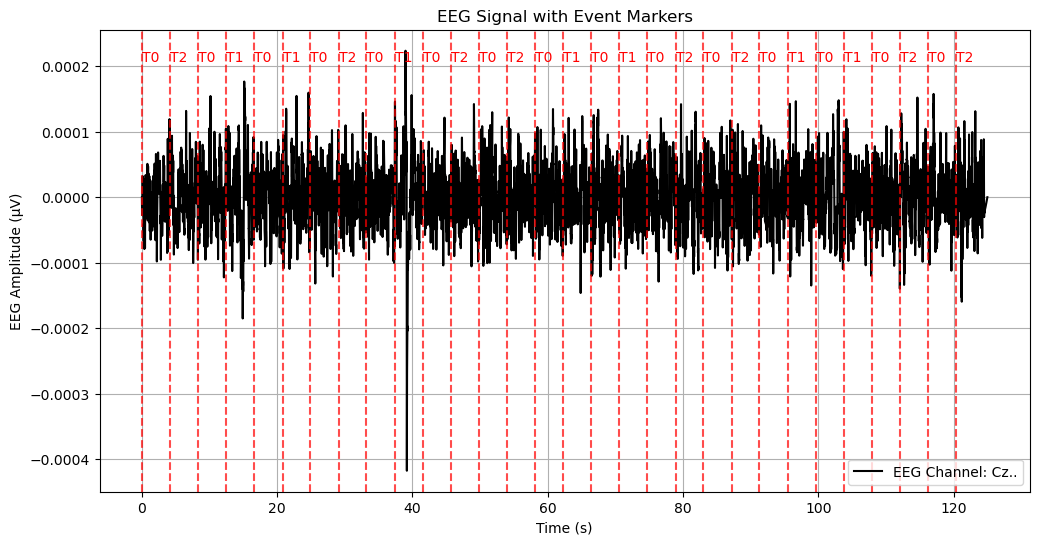

Not setting metadata
30 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)


/var/folders/g7/2jrpz1td1gvfhtddsqp_957c0000gn/T/ipykernel_73152/2004423450.py:57: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)
/opt/anaconda3/lib/python3.12/site-packages/mne/viz/utils.py:137: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


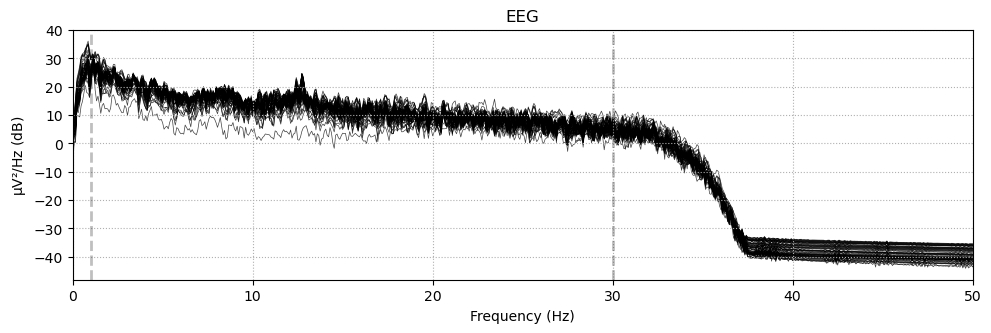

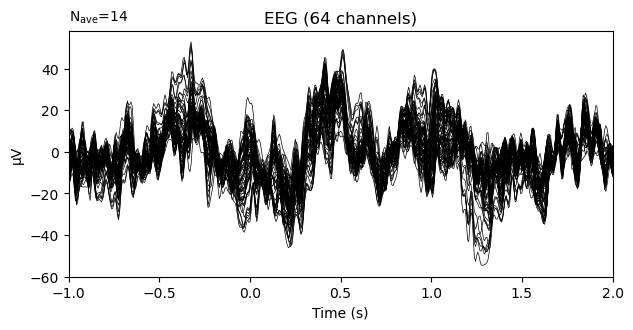

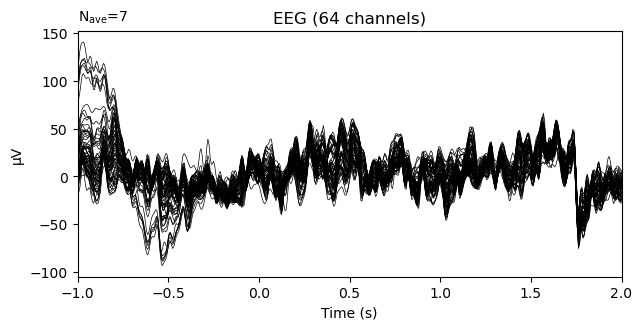

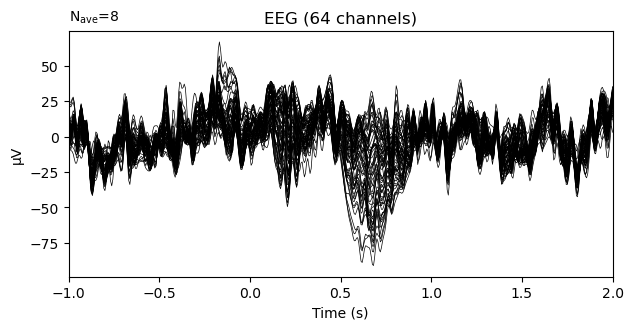

In [7]:
edf_file_path = "./files/S001/S001R06.edf"
event_file_path = "./files/S001/S001R06.edf.event"
raw = mne.io.read_raw_edf(edf_file_path, preload=True)

# apply band-pass filter
raw.filter(1, 30, fir_design='firwin')
raw.notch_filter(60, fir_design='firwin')


# Read EEG data
eeg_data, times = raw[:,:]

# Read event markers
event_times = raw.annotations.onset  # event times
event_labels = raw.annotations.description  # event labels

# Read event data
with open(event_file_path, "rb") as f:
    event_data = f.read()

# Decode event data
decoded_text = event_data.decode("utf-8", errors="ignore")
event_pattern = re.findall(r'(T[012]) duration: (\d+\.\d+)', decoded_text)
parsed_events = [{"Event": match[0], "Duration (s)": float(match[1])} for match in event_pattern]
df_events = pd.DataFrame(parsed_events)

# Select EEG channel
channel_idx = raw.ch_names.index("Cz..") # most important channel for motor movement
eeg_signal = eeg_data[channel_idx]

# apply low-pass filter
eeg_signal = butter_lowpass_filter(eeg_signal, cutoff=30, fs=160, order=4)


# 1. Plot EEG signal with event markers
plt.figure(figsize=(12, 6))
plt.plot(times, eeg_signal, label=f"EEG Channel: {raw.ch_names[channel_idx]}", color="black")

for etime, elabel in zip(event_times, event_labels):
    plt.axvline(x=etime, color="red", linestyle="--", alpha=0.7)
    plt.text(etime, np.max(eeg_signal), elabel, color="red", fontsize=10, verticalalignment='top')

plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Signal with Event Markers")
plt.legend()
plt.grid()
plt.show()

# 2. (T0, T1, T2) event markers
event_id = {"T0": 1, "T1": 2, "T2": 3}
events = np.array([[int(t * raw.info["sfreq"]), 0, event_id[l]] for t, l in zip(event_times, event_labels)])

epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-1.0, tmax=2.0, baseline=(None, 0), detrend=1)

# 3. Plot Power Spectral Density (PSD)
raw.plot_psd(fmax=50)

# 4. Plot Event-Related Potential (ERP)
evoked_T0 = epochs['T0'].average()
evoked_T1 = epochs['T1'].average()
evoked_T2 = epochs['T2'].average()

fig = evoked_T0.plot()
fig = evoked_T1.plot() # ERP for T1 (Left/Both Fist Movement)
fig = evoked_T2.plot() # "ERP for T2 (Right Fist/Both Feet Movement)
